In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial import distance
import math
from keras.models import save_model,load_model

%matplotlib inline

2024-08-22 13:19:35.724510: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 13:19:35.932073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 13:19:36.131144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 13:19:36.305542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 13:19:36.354668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 13:19:36.663234: I tensorflow/core/platform/cpu_feature_gu

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("detector/shape_predictor_68_face_landmarks.dat")

In [22]:
def get_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_facial_landmarks(gray):
    face_rects = detector(gray, 1)
    if (len(face_rects)==0):
        return -1
    face_landmarks = predictor(image, face_rects[0])
    face_landmarks = np.array([[p.x, p.y] for p in face_landmarks.parts()])
    return face_landmarks

def eye_aspect_ratio(eye_landmarks):
    # Calculate the distances between the horizontal eye landmarks
    A = np.linalg.norm(eye_landmarks[1] - eye_landmarks[5])
    B = np.linalg.norm(eye_landmarks[2] - eye_landmarks[4])
    C = np.linalg.norm(eye_landmarks[0] - eye_landmarks[3])

    # Calculate the Eye Aspect Ratio (EAR)
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth_landmarks):
    # Calculate the distances between the vertical mouth landmarks
    A = np.linalg.norm(mouth_landmarks[13] - mouth_landmarks[19])
    B = np.linalg.norm(mouth_landmarks[14] - mouth_landmarks[18])
    C = np.linalg.norm(mouth_landmarks[15] - mouth_landmarks[17])
    D = np.linalg.norm(mouth_landmarks[12] - mouth_landmarks[16])

    # Calculate the Mouth Aspect Ratio (MAR)
    mar = (A + B + C) / (2.0 * D)
    return mar

def facial_asymmetry(facial_landmarks):
    # Calculate the center of the face by averaging the landmarks
    face_center = np.mean(facial_landmarks, axis=0)

    # Calculate the distances between each landmark and the face center
    distances = np.linalg.norm(facial_landmarks - face_center, axis=1)

    # Calculate the facial asymmetry as the standard deviation of the distances
    asymmetry = np.std(distances)
    return asymmetry

def get_features(land_marks):
    eye_landmarks = land_marks[36:42]
    mouth_landmarks = land_marks[48:68]
    ear = eye_aspect_ratio(eye_landmarks)
    mar = mouth_aspect_ratio(mouth_landmarks)
    fa = facial_asymmetry(land_marks)
    
    return ear, mar, fa

In [23]:
image = cv2.imread("test-images/angry.jpeg")
image = get_gray(image)

In [24]:
landmarks = get_facial_landmarks(image)

In [25]:
landmarks.shape

(68, 2)

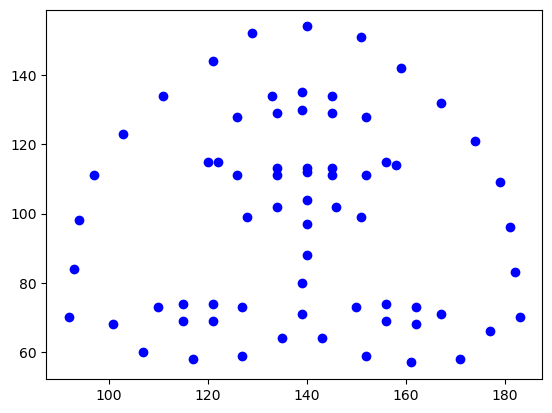

In [26]:
for i in range(landmarks.shape[0]):
    plt.scatter(landmarks[i][0],landmarks[i][1], color='blue')

In [27]:
eye_aspect_ratio(landmarks)

0.9649484129345225

In [28]:
facial_asymmetry(landmarks)

14.073716009358415

In [30]:
ear, mar, fa = get_features(landmarks)
ear, mar, fa

(0.29411764705882354, 0.7210203877342117, 14.073716009358415)

In [57]:
s = get_facial_landmarks(image)

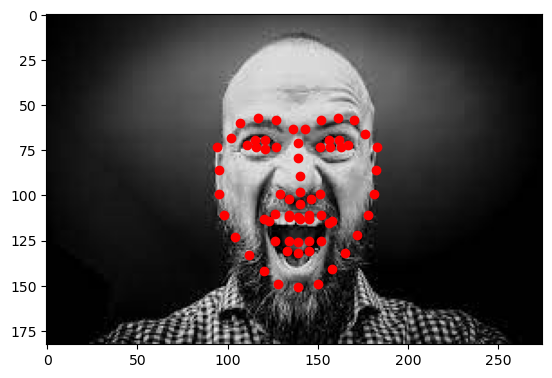

In [53]:
test_image = cv2.imread("test-images/angry.jpeg")
f_ldm = get_facial_landmarks(test_image)

plt.imshow(test_image)
for i in range(f_ldm.shape[0]):
    plt.scatter(f_ldm[i][0],f_ldm[i][1] , color='red')

In [54]:
def get_labeled_face(image, s):
    # img = cv2.imread("def.jpeg")
    mouth = cv2.rectangle(image,(s[48][0]-5, s[51][1]-5),(s[54][0]+5, s[57][1]+8) ,color = (255,1,1))
    #left eye
    left_eye = cv2.rectangle(image,(s[18][0]-5, s[18][1]-5),(s[21][0]+5, s[41][1]+8) ,color = (255,1,1))
    #right eye
    right_eye = cv2.rectangle(image,(s[22][0]-5, s[22][1]-5),(s[25][0]+5, s[46][1]+5) ,color = (255,1,1))
    
    return image, mouth, left_eye, right_eye   


# mx = s[48][0]-5
# mxw = s[54][0]+5
# my = s[51][1]-7
# myh = s[57][1]+8

# lx = s[18][0]-8
# lxw = s[21][0]+5
# ly = s[18][1]-8
# lyh = s[41][1]+8

# rx = s[22][0]-8
# rxw = s[25][0]+5
# ry = s[22][1]-9
# ryh = s[46][1]+5
# mouth = image[ my:myh , mx:mxw ]
# l_eye = image[ ly:lyh , lx:lxw ]
# r_eye = image[ ry:ryh , rx:rxw ]

# l_eye = cv2.resize(l_eye, (256,256))
# r_eye = cv2.resize(r_eye, (256,256))
# mouth = cv2.resize(mouth, (256,256))

In [55]:
image, mouth, left_eye, right_eye = get_labeled_face(test_image, s=f_ldm)

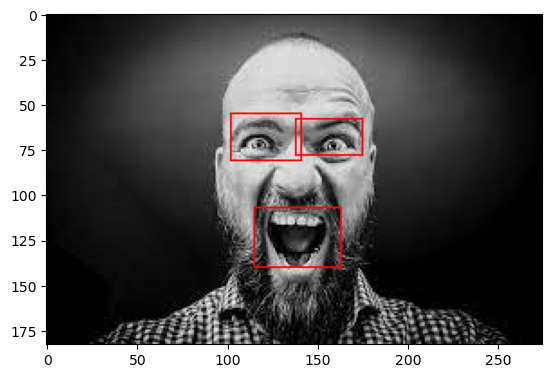

In [56]:
plt.imshow(image)

In [71]:
# crop_img = test_image[f_ldm[48][1]-5: f_ldm[57][1]+5 , f_ldm[48][0]-5 : f_ldm[54][0]+5]

In [ ]:
import cv2

# Read the input image
img = cv2.imread('mpw.jpeg')

# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    cv2.imshow("face",faces)
    cv2.imwrite('face.jpg', faces)
    
# Display the output
cv2.imwrite('detcted.jpg', img)
plt.imshow('img', img)

In [51]:
for i in range(68):
    if i>=1 and i<=5:
        color = "red"
    else:
        color = "black"
    plt.scatter(shape[i][0],shape[i][1] , color=color)

NameError: name 'shape' is not defined